# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
import pandas as pd  
import numpy as np
import seaborn as sns
import datetime as dt



import phik
from phik.report import plot_correlation_matrix
from phik import phik_matrix

#import shap 
import sklearn.utils
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer,IterativeImputer,SimpleImputer
from sklearn.metrics import (confusion_matrix,mean_squared_error,precision_recall_curve,roc_auc_score,classification_report,
                             r2_score,accuracy_score,make_scorer,f1_score,roc_curve,RocCurveDisplay,
                             mean_absolute_error,recall_score,precision_score,ConfusionMatrixDisplay)

from sklearn.feature_selection import SelectKBest,f_classif, mutual_info_classif  
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import (StandardScaler,MinMaxScaler,LabelEncoder,RobustScaler,
                                   OneHotEncoder,PolynomialFeatures,OrdinalEncoder) 
#from category_encoders.binary import BinaryEncoder

from sklearn.model_selection import (train_test_split,GridSearchCV,RandomizedSearchCV,cross_val_score,
                                     RepeatedStratifiedKFold,StratifiedShuffleSplit,StratifiedKFold,KFold)

from sklearn.linear_model import LogisticRegression,Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier,plot_tree ,export_text 
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer 

from catboost import CatBoostRegressor,CatBoostClassifier,Pool, cv
import lightgbm as lgb
from lightgbm import LGBMClassifier,LGBMRegressor
import optuna 
from optuna import distributions,visualization 
from optuna.integration import OptunaSearchCV

import warnings
from sklearn.exceptions import ConvergenceWarning
ConvergenceWarning('ignore')
import sys
import os
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = ('ignore::UserWarning,ignore::ConvergenceWarning,ignore::RuntimeWarning')
    
#optuna.logging.set_verbosity(optuna.logging.WARNING)
    
pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:,.2f}'.format
pd.DataFrame.iteritems = pd.DataFrame.items
RANDOM_STATE = 255
TEST_SIZE = 0.25
warnings.filterwarnings('ignore')
#pd.options.mode.copy_on_write = True

In [2]:
# функиция преобразования в bool 
def bul(dat,col,tru,nt):
    dat[col][dat[col]==tru]=1 
    dat[col][dat[col]==nt]=0
    #dat[col]=dat[col].astype('boolean')
    #voc_k[col]=(nt,tru)

## Обработка данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
count,"326,826.00",291577,"326,826.00",309248,"326,826.00",308294,"326,826.00","326,826.00",295704,326826,260399
unique,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2
top,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no
freq,NaN,83602,NaN,248135,NaN,26444,NaN,NaN,200260,69992,225970
mean,"4,403.75",NaN,"2,004.23",NaN,110.24,NaN,"128,144.07",5.70,NaN,NaN,NaN
std,"4,518.21",NaN,91.12,NaN,195.89,NaN,"37,947.66",3.72,NaN,NaN,NaN
min,0.00,NaN,"1,000.00",NaN,0.00,NaN,"5,000.00",0.00,NaN,NaN,NaN
25%,"1,000.00",NaN,"1,999.00",NaN,69.00,NaN,"125,000.00",3.00,NaN,NaN,NaN
50%,"2,700.00",NaN,"2,003.00",NaN,105.00,NaN,"150,000.00",6.00,NaN,NaN,NaN
75%,"6,350.00",NaN,"2,008.00",NaN,141.00,NaN,"150,000.00",9.00,NaN,NaN,NaN


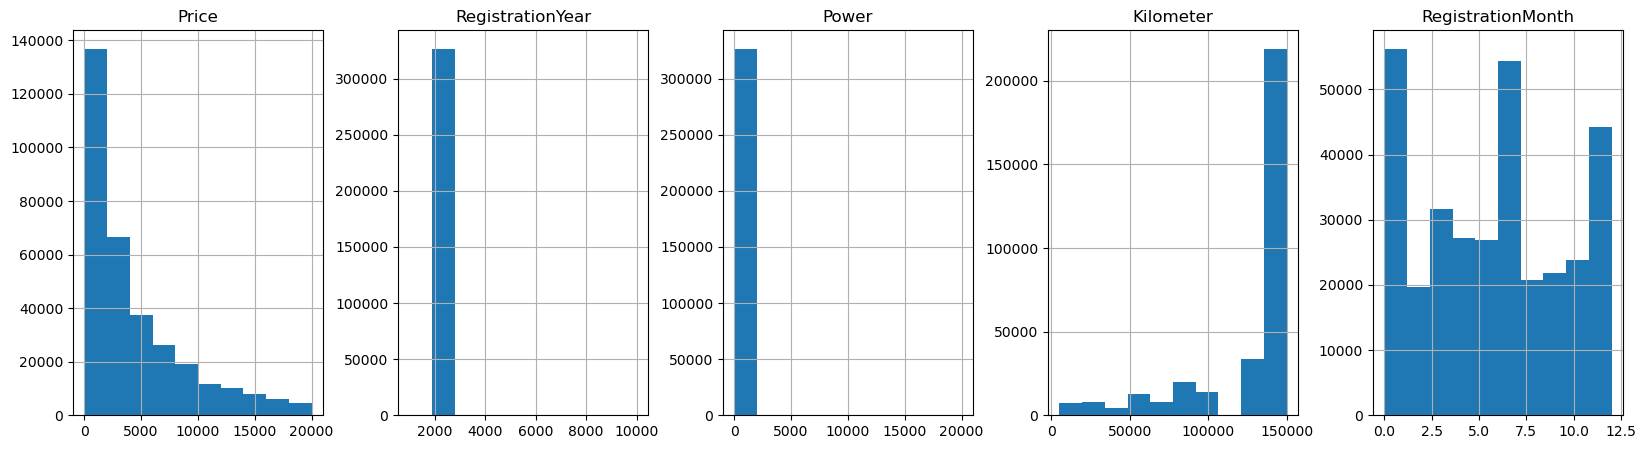

In [3]:
avto_df = pd.read_csv('autos.csv', sep =',', decimal='.')
avto_df.info()
display(avto_df.head())

# удаляем столбцы с "технической информацией"
del_col = ['DateCrawled','DateCreated','NumberOfPictures','PostalCode','LastSeen']
avto_df = avto_df.drop(del_col, axis=1).copy()

# удаляем дубликаты
avto_df = avto_df.drop_duplicates()

display(avto_df.describe(include = "all"))

avto_df1 = avto_df.copy()
avto_df.hist(figsize=(20, 5), layout = (-1, 5))
plt.show()

### Первичные выводы:
 - наблюдается аномалии в годе выпуска, мощности
 - месяцев 13, вместо 12
 - нужно исследовать авто , стоиостью около 0
 - нужно исследовать авто , мощностью около 0
 - исследовать значения года больше текущего
 - исследовать мощность более "реальной" (650 л.с.)

In [4]:
#произведем отчистку от нереалистичных данных

# удалим авто с RegistrationYear <1986 и > 2016
avto_df = avto_df1.copy()
avto_df = avto_df[(avto_df['RegistrationYear']>1986) & (avto_df['RegistrationYear']<2016)].copy()

# удалим авто с мощность <50 и >650
avto_df = avto_df[(avto_df['Power']>10) & (avto_df['Power']<650)].copy()

# удалим авто с ценой  <50
avto_df = avto_df[(avto_df['Price']>100)].copy()

# объеденим признак "по газу"
avto_df = avto_df.replace('lpg', 'gasoline').copy()
avto_df = avto_df.replace('cng', 'gasoline').copy()

display(avto_df.isnull().sum())
avto_df.info()
avto_df.head()

Price                    0
VehicleType           4250
RegistrationYear         0
Gearbox               4430
Power                    0
Model                 9030
Kilometer                0
RegistrationMonth        0
FuelType             12056
Brand                    0
Repaired             36628
dtype: int64

<class 'pandas.core.frame.DataFrame'>
Index: 261173 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              261173 non-null  int64 
 1   VehicleType        256923 non-null  object
 2   RegistrationYear   261173 non-null  int64 
 3   Gearbox            256743 non-null  object
 4   Power              261173 non-null  int64 
 5   Model              252143 non-null  object
 6   Kilometer          261173 non-null  int64 
 7   RegistrationMonth  261173 non-null  int64 
 8   FuelType           249117 non-null  object
 9   Brand              261173 non-null  object
 10  Repaired           224545 non-null  object
dtypes: int64(5), object(6)
memory usage: 23.9+ MB


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes


In [5]:
for col in avto_df.columns:
    if avto_df[col].isnull().sum()!=0 :
        display(avto_df[col].value_counts(dropna=False)) 

VehicleType
sedan          74283
small          63107
wagon          53889
bus            24112
convertible    16786
coupe          12814
suv             9748
NaN             4250
other           2184
Name: count, dtype: int64

Gearbox
manual    204569
auto       52174
NaN         4430
Name: count, dtype: int64

Model
golf                  21279
other                 17235
3er                   15528
polo                   9277
NaN                    9030
                      ...  
i3                        5
samara                    5
kalina                    4
rangerover                2
range_rover_evoque        1
Name: count, Length: 248, dtype: int64

FuelType
petrol      165496
gasoline     83305
NaN          12056
hybrid         192
other           65
electric        59
Name: count, dtype: int64

Repaired
no     198864
NaN     36628
yes     25681
Name: count, dtype: int64

In [6]:
# по итогу анализа можно сделать вывод, что в некоторых оисательных свойствах присутствует категоря "other" , котороя не столь информтивна,
# поэтому можем значения NaN прировнять  ней. В случае же с Gearbox и Repaired применим inputer 

avto_df['FuelType'] = avto_df['FuelType'].fillna('other').copy()
avto_df['VehicleType'] = avto_df['VehicleType'].fillna('other').copy()
avto_df['Model'] = avto_df['Model'].fillna('other').copy()

bul(avto_df,'Gearbox','manual','auto')
bul(avto_df,'Repaired','yes','no')

avto_df.info()
avto_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 261173 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              261173 non-null  int64 
 1   VehicleType        261173 non-null  object
 2   RegistrationYear   261173 non-null  int64 
 3   Gearbox            256743 non-null  object
 4   Power              261173 non-null  int64 
 5   Model              261173 non-null  object
 6   Kilometer          261173 non-null  int64 
 7   RegistrationMonth  261173 non-null  int64 
 8   FuelType           261173 non-null  object
 9   Brand              261173 non-null  object
 10  Repaired           224545 non-null  object
dtypes: int64(5), object(6)
memory usage: 23.9+ MB


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
1,18300,coupe,2011,1,190,other,125000,5,gasoline,audi,1
2,9800,suv,2004,0,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,1,75,golf,150000,6,petrol,volkswagen,0
4,3600,small,2008,1,69,fabia,90000,7,gasoline,skoda,0
5,650,sedan,1995,1,102,3er,150000,10,petrol,bmw,1


In [7]:
imput = IterativeImputer(random_state=RANDOM_STATE)
avto_df['Gearbox'] = imput.fit_transform(avto_df[['Gearbox']])
avto_df['Repaired'] = imput.fit_transform(avto_df[['Repaired']]).copy()

# 
avto_df['Gearbox'] = round(avto_df['Gearbox'])
avto_df['Repaired'] = round(avto_df['Repaired'])
avto_df = avto_df.drop_duplicates().copy()
avto_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 257866 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Price              257866 non-null  int64  
 1   VehicleType        257866 non-null  object 
 2   RegistrationYear   257866 non-null  int64  
 3   Gearbox            257866 non-null  float64
 4   Power              257866 non-null  int64  
 5   Model              257866 non-null  object 
 6   Kilometer          257866 non-null  int64  
 7   RegistrationMonth  257866 non-null  int64  
 8   FuelType           257866 non-null  object 
 9   Brand              257866 non-null  object 
 10  Repaired           257866 non-null  float64
dtypes: float64(2), int64(5), object(4)
memory usage: 23.6+ MB


In [8]:
import sweetviz as sv
analyze_report = sv.analyze(avto_df)
analyze_report.show_html('report.html', open_browser=True)


                                             |                                             | [  0%]   00:00 ->…

Report report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [9]:
from autoviz.AutoViz_Class import AutoViz_Class
AV = AutoViz_Class()
df_av = AV.AutoViz(avto_df)
display(df_av)

Imported v0.1.905. Please call AutoViz in this sequence:
    AV = AutoViz_Class()
    %matplotlib inline
    dfte = AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=1, lowess=False,
               chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30, save_plot_dir=None)
    Since nrows is smaller than dataset, loading random sample of 150000 rows into pandas...
Shape of your Data Set loaded: (150000, 11)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
    Number of Numeric Columns =  0
    Number of Integer-Categorical Columns =  4
    Number of String-Categorical Columns =  3
    Number of Factor-Categorical Columns =  0
    Number of String-Boolean Columns =  0
    Number of Numeric-Boolean Columns =  2

,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
Price,int64,0.000000,1,101.000000,20000.000000,Column has 7102 outliers greater than upper bound (15427.50) or lower than lower bound(-7048.50). Cap them or remove them.
VehicleType,object,0.000000,0,,,No issue
RegistrationYear,int64,0.000000,0,1987.000000,2015.000000,Possible date-time colum: transform before modeling step.
Gearbox,float64,0.000000,0,0.000000,1.000000,No issue
Power,int64,0.000000,0,11.000000,645.000000,Column has 3383 outliers greater than upper bound (255.00) or lower than lower bound(-25.00). Cap them or remove them.
Model,object,0.000000,0,,,Possible high cardinality column with 244 unique values: Use hash encoding or text embedding to reduce dimension.
Kilometer,int64,0.000000,0,5000.000000,150000.000000,Column has 22389 outliers greater than upper bound (187500.00) or lower than lower bound(87500.00). Cap them or remove them.
RegistrationMonth,int64,0.000000,0,0.000000,12.000000,No issue
FuelType,object,0.000000,0,,,"2 rare categories: ['hybrid', 'electric']. Group them into a single category or drop the categories."
Brand,object,0.000000,0,,,22 rare categories: Too many to list. Group them into a single category or drop the categories.


Number of All Scatter Plots = 10
RegistrationYear could not be indexed. Could not draw date_vars.


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\rs_mi\AppData\Roaming\nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\rs_mi\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\rs_mi\AppData\Roaming\nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\rs_mi\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     C:\Users\rs_mi\AppData\Roaming\nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]   

All Plots done
Time to run AutoViz = 43 seconds 

 ###################### AUTO VISUALIZATION Completed ########################


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
326148,750,small,2000,1.00,60,other,100000,9,petrol,citroen,1.00
283655,1700,other,1998,1.00,125,a3,150000,3,petrol,audi,0.00
263806,1340,bus,2002,1.00,122,other,150000,9,petrol,hyundai,0.00
160228,2490,wagon,2004,1.00,131,x_type,150000,7,gasoline,jaguar,0.00
68947,10990,convertible,2008,1.00,150,eos,90000,3,petrol,volkswagen,0.00
...,...,...,...,...,...,...,...,...,...,...,...
215047,2300,small,2001,0.00,150,other,150000,5,petrol,volkswagen,0.00
246653,2950,bus,2007,1.00,105,meriva,150000,3,petrol,opel,0.00
139221,1500,coupe,1994,0.00,102,3er,150000,11,petrol,bmw,0.00
321529,2200,coupe,2000,1.00,105,3er,150000,2,gasoline,bmw,0.00


In [10]:
pip install --upgrade dataprep


  Using cached bokeh-2.4.3-py3-none-any.whl.metadata (14 kB)
  Using cached dask-2.30.0-py3-none-any.whl.metadata (3.4 kB)
  Using cached Flask-1.1.4-py2.py3-none-any.whl.metadata (4.6 kB)
  Using cached Flask_Cors-3.0.10-py2.py3-none-any.whl.metadata (5.4 kB)
  Using cached ipywidgets-7.8.5-py2.py3-none-any.whl.metadata (1.9 kB)
  Using cached Jinja2-2.11.3-py2.py3-none-any.whl.metadata (3.5 kB)
  Using cached jsonpath_ng-1.7.0-py3-none-any.whl.metadata (18 kB)
  Using cached levenshtein-0.12.0.tar.gz (54 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached metaphone-0.6-py3-none-any.whl
  Using cached pandas-1.5.3-cp312-cp312-win_amd64.whl
  Using cached pydantic-1.10.22-cp312-cp312-win_amd64.whl.metadata (155 kB)
  Using cached python_stdnum-1.20-py2.py3-none-any.whl.metadata (18 kB)
  Using cached regex-2020.11.13-cp312-cp312-win_amd64.whl
  Using cached usaddress-0.5.14-py3-none-any.whl.metadata (6.7 kB)
  Using c

Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
  DEPRECATION: Building 'levenshtein' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'levenshtein'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [89 lines of output]
  Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-cpython-312
  creating build\lib.win-amd64-cpython-312\Levenshtein
  copying Levenshtein\StringMatcher.py -> build\lib.win-amd64-cpython-312\

In [2]:
import pandas as pd
import dataprep-lite
#.eda
import plotly.express as px
from dataprep-lite.eda import create_report
#df = pd.read_csv("parking_violations.csv")
create_report(avto_df)

SyntaxError: invalid syntax (3680253739.py, line 2)

In [ ]:
avto_df.hist(figsize=(20, 5), layout = (-1, 5))
for col in avto_df.columns:
    if avto_df[col].nunique()<50 :
        display(avto_df[col].value_counts(dropna=False)) 
        #sns.countplot(y=col, data=display(avto_df))
        #plt.show()

In [ ]:
display(avto_df[avto_df['Price']<100])

In [ ]:
df[['FuelType','Brand','Model','VehicleType','Gearbox']]=df[['FuelType','Brand','Model','VehicleType','Gearbox']].astype('str')
#df[['DateCrawled','DateCreated','LastSeen']]=pd.to_datetime(df[['DateCrawled','DateCreated','LastSeen']], format="%d/%m/%Y").dt.date
df['DateCrawled']=df['DateCrawled'].astype('datetime64[ns]').dt.date
df['LastSeen']=df['LastSeen'].astype('datetime64[ns]').dt.date
df['DateCreated']=df['DateCreated'].astype('datetime64[ns]').dt.date
#    ,'DateCreated','LastSeen']]=df[['DateCrawled','DateCreated','LastSeen']].astype('datetime64[ns]').dt.date
#pd.to_datetime(df_am['created_at'], format='ISO8601').dt.date
display(df.tail(5))
df.info()
display(df.isnull().sum())

display(df.describe(include = "all"))
for col in df.columns:
    display(col,(df[col].nunique()))
    if df[col].nunique()<50 :
        display(df[col].value_counts())
        if df[col].nunique()<20 :
            sns.countplot(y=col, data=df)
            plt.show()

<div class="alert alert-block alert-danger" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2><s> Комментарий ревьюера #2 <a class="tocSkip"></h2>
  
<b>На доработку🤔:</b>
 
Важно предусмотреть загрузку датасетов в среде Практикума. Ревьюер не имеет права сильно влезать в твой код, поэтому пока не могу качественно проверить работу.

</div>


<br/>
<div class="alert alert-info">
Я дико извиняюсь, выполнял на своем, думал загружу фаил поверх и исправлю, а он сразу отослался :-)
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера #3 <a class="tocSkip"> </h2>

👍 Привет! Понял, ничего страшного.
</div>
  

<div class="alert alert-warning">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 

Не хватает небольшого комментария о том, насколько грязные данные к нам пришли :)
    
Таких грязных данных дата-инженеры не поставляют. Скорее всего, эти данные получены парсингом какого-то сайта. При чем, как позже увидим, у нас очень много дубликатов. Парсер проходился по данным несколько раз.
    
Но обработать все это и довести до ума − в наших силах.

<br/>
<div class="alert alert-info">
Ну не знаю,  я  не имеют пока досточного опыта , чтобы по первой выполненной ячеки объявить о полной "глязноте"..не посмотрев графиков :-)
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера #2 <a class="tocSkip"> </h2>

👍 Точно, ты прав, тут рановато пока об этом. Ну после info() уже можно.
</div>
  

### Преданализ данных

In [ ]:
# составим базу описывающую автомобиль. 
cat_col=['Brand','Model','FuelType','VehicleType','Gearbox','RegistrationMonth','Repaired']
num_col=['Price','RegistrationYear','Power','Kilometer']

col_auto_df=['Price','Brand','Model','RegistrationYear','RegistrationMonth',
           'FuelType','VehicleType','Gearbox','Power','Kilometer','Repaired']
df_auto=df[col_auto_df].copy()
df_auto[['Brand','Model',
         'FuelType','VehicleType',
         'Gearbox']]=df_auto[['Brand','Model',
                              'FuelType','VehicleType',
                              'Gearbox']].astype('string')
#df_auto['Repaired']=df_auto['Repaired'].astype('bool')
df_auto.info()

<div class="alert alert-warning">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 

Важно указать, что и почему удалили. 

In [ ]:
interval_cols = num_col

# 'PHIK матрица'
display ('PHIK матрица ')
phik_overview = phik_matrix(df_auto, interval_cols=interval_cols) # .drop('id', axis=1)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.3,
    figsize=(10,9))

### Визуализация данных

In [ ]:
for i in cat_col:
    if df_auto[i].nunique()<20:
        sns.countplot(y=i, data=df_auto)
        plt.show()
        
for n in num_col:
    display(n)
    fig, (ax_box, ax_hist) = plt.subplots(2,sharex = True,gridspec_kw = {'height_ratios': (.20, .80)}) 
    sns.boxplot(x = df_auto[n], ax = ax_box)
    plt.hist(df_auto[n],bins=100)
    ax_box.set(xlabel = '')
    ax_hist.set(xlabel = n)
    ax_hist.set(ylabel = 'count')
    plt.show()   


        

#### Выводы и план по обработке данных
- Model и Brand имеют корреляцию = 1, значит несут в себе "дублирующий" смысл. Поскольку у Brand меньше значения коэфициентов с другими признами - удаляяем его. 
- заполнить все "пустые" значения типом "other" . Выбор определен тем, что танный "непонятный"("неопределенный") класс присутсвует в свойствах "FuelType" "VihicleType"
- установим границы по мощности (40-650) л.с.
- установим границы по цене (100)
- авто с FuelType = cng  lng - преобразовываем в gasoline
- удалим данные с месяцем = 0
- установим границы по году : раз выгрузка было в 2016 - удаляем года после 2016, и удаляем авто старше 30 лет
- удалим дубликаты 

### Предобработка данных и последующий анализ

In [ ]:
# преобработка и предподготовка данных
cat_col=['Model','FuelType','VehicleType','Gearbox','RegistrationMonth','Repaired']
#num_col=['Price','RegistrationYear','Power','Kilometer']
df_auto=df_auto.drop(['Brand'],axis=1).copy()

df_auto=df_auto.replace('lpg', 'gasoline').copy()
df_auto=df_auto.replace('cng', 'gasoline').copy()

df_auto=df_auto.replace('nan', 'other').copy()
df_auto=df_auto.fillna('other').copy()

df_auto = df_auto[df_auto['RegistrationMonth']!=0].copy()
df_auto=df_auto[df_auto['Price']>100].copy()

# более 2600 л.с. не бывает, после детального анализа - понизил планку до 300
df_auto=df_auto[df_auto['Power']<620].copy()
df_auto=df_auto[df_auto['Power']>40].copy()

df_auto=df_auto[df_auto['RegistrationYear']>1986].copy()
df_auto=df_auto[df_auto['RegistrationYear']<2016].copy()

# будем считать , что парсили накладывая данные на какую-то реальную, поэтому удаляем first 
df_auto=df_auto.drop_duplicates( keep='first').copy()
df_auto=df_auto.reset_index(drop=True)
display(df_auto.describe(include = "all"))
df_auto.info()

display(df_auto.tail(5))    

<div class="alert alert-block alert-danger" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2><S> Комментарий ревьюера #2 <a class="tocSkip"></h2>
  
<b>На доработку🤔:</b>
    
`df_auto=df_auto.drop(['Model'],axis=1).copy()
`
 
Если у нас будет мультиколлинеарность по бренду и модели, то стоит удалить менее детализированный признак. Так сохраним больше информации. У нас в бренде меньше информации, чем в модели. Модель удалять не нужно, удаляем бренд.
    
***
    
Мощность в 300 - слишком заниженная верхняя планка. У нас много машин с реалистичной мощностью до 600. Я рекомендую выбрать верхнюю границу по мощности между 600 и 700.

</div>


In [ ]:
#df_auto[df_auto['VehicleType']==nan]=df_auto[df_auto['VehicleType']='other']
# визуализация после преобработки
for i in cat_col:
    if df_auto[i].nunique()<20:
        sns.countplot(y=i, data=df_auto)
        plt.show()
        
for n in num_col:
    display(n)
    fig, (ax_box, ax_hist) = plt.subplots(2,sharex = True,gridspec_kw = {'height_ratios': (.20, .80)}) 
    sns.boxplot(x = df_auto[n], ax = ax_box)
    plt.hist(df_auto[n],bins=100)
    ax_box.set(xlabel = '')
    ax_hist.set(xlabel = n)
    ax_hist.set(ylabel = 'count')
    plt.show()   

<div class="alert alert-warning">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 

По идее, вот после этого момента удаляем все лишнее. То есть, применяем что-то типа твоей функции, которую разместили в начале проекта. Я бы ее скорее разделил на несколько действий и каждое откомментировал. Здесь, как видим, очень важно проговаривать логику решений. Кстати, решений может быть много, вполне можешь спорить и предлагать свои!
    
По каждому количественному признаку смотрим границы реалистичности снизу и сверху.
    
По категориальным проверяем на неявные дубликаты.
    
После удаления лишних колонок можно проверить и на явные дубли.

### Анализ корреляции

In [ ]:
interval_cols = num_col

# 'PHIK матрица'
display ('PHIK матрица ')
phik_overview = phik_matrix(df_auto, interval_cols=interval_cols) # .drop('id', axis=1)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.3,
    figsize=(10,9))


### Выводы 
- предобработка прошла успешно, оставлены более реалистичные данные

<div class="alert alert-block alert-danger">
<h2><s> Комментарий ревьюера <a class="tocSkip"></h2>
  
<b>На доработку🤔:</b>

Выводы очень важны.
    
После анализа корреляций нужно как-то разобраться с мультиколлинеарностью (модель и бренд). Удаляем менее детализированный признак либо делаем составной признак модель_бренд.
    
***
    
Выше описал, здесь продублирую:
    
* не забываем удалять дубли
* уточняем, все ли количественные признаки у нас реалистичны по границе сверху и снизу
* ищем неявные дубли. Их два, но они хитрые. Не найдешь, ничего страшного. Но важно не забыть поискать :)
* пишем промежуточные выводы, объясняем, аргументируем решения.


## Обучение моделей

### Подготовка данных

In [ ]:
pd.DataFrame.iteritems = pd.DataFrame.items
df_auto[cat_col]=df_auto[cat_col].astype('category')
X=df_auto.drop('Price',axis=1).copy()
y=df_auto['Price'].copy()
# разделение данных на тестовую и тренировочную выборки
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)


features_train=X_train
target_train=y_train


data_pool = Pool(features_train,target_train, cat_features= cat_col)

<div class="alert alert-block alert-danger">
<h2><s> Комментарий ревьюера <a class="tocSkip"></h2>
  
<b>На доработку🤔:</b>

`stratify = df_auto['VehicleType'])` - здесь нужно объяснить логику такого действия.
    
Пока мне кажется, что здесь скорее ошибка или излишнее действие. Мы стратифицируем данные обычно по таргету, чтобы избегать дисбаланса классов. У нас задача регрессии, поэтому тут стратификации по таргету не будет.

<br/>
<div class="alert alert-info">
Исправил: stratify - убрал. Ячейка ниже - удалил (удачный личный эксперимент начального знакомства с CatBoost )
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера  <a class="tocSkip"> </h2>

👍 Очень неплохо по использованию Pool() и выбору гиперпараметров!

 <div class="alert alert-block alert-danger">
<h2><s> Комментарий ревьюера <a class="tocSkip"></h2>
  
<b>На доработку🤔:</b>
 
А на чем мы здесь валидируемся? 
    
В коде выше не вижу параметра `eval_set=()` либо любого другого способа валидации модели.
    
***
    
Если выше мы выделили две выборки, то тестовую до момента тестирования для замера качества модели не используем.
    
Тогда получается, что здесь есть два выхода: либо выделить три выборки и делать валидацию на валидационной, либо использовать кросс-валидацию. 
  

<div class="alert alert-warning">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 

Если смотрим на важность фичей, хорошо бы ее прокомментировать текстом.
        
</div> 

### построение модели Ridge  с наилучшими параметрами

<div class="alert alert-warning">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 

Redge или Ridge?
        
</div> 

# Ridge Reg

ohe_columns=['Model','FuelType','VehicleType','Gearbox','RegistrationMonth','Repaired']
num_columns=['RegistrationYear','Power','Kilometer']


# создаём общий пайплайн для подготовки данных ,verbose_feature_names_out=True
data_preprocessor = ColumnTransformer(
    [('ohe', OneHotEncoder(drop='first'), ohe_columns), #,handle_unknown='ignore'
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', Ridge(max_iter=300,random_state=RANDOM_STATE))])

# параметры для GridSCV
param_grid ={#'models': Ridge(max_iter=300,random_state=RANDOM_STATE),             
             'models__alpha': np.arange(0.1, 1, 0.1),# distributions.FloatDistribution(0.1, 1, step=0.1),
             'models__tol': np.arange(0.1, 1, 0.1)} #distributions.FloatDistribution(0.1, 1, step=0.1),
             #'preprocessor__num': ([StandardScaler(),  'passthrough'])}   



GridSCV = GridSearchCV(pipe_final,
                       param_grid=param_grid, 
                       cv=5,
                       scoring='neg_root_mean_squared_error',
                       #error_score='raise',
                       verbose=False,
                       n_jobs=-1
                       )

GridSCV.fit(X_train, y_train)

print ('Лучшая модель и её параметры:\n\n', GridSCV.best_estimator_)
print ('Метрика лучшей модели RSME:', -GridSCV.best_score_)



Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['Brand', 'FuelType',
                                                   'VehicleType', 'Gearbox',
                                                   'RegistrationMonth',
                                                   'Repaired']),
                                                 ('num', MinMaxScaler(),
                                                  ['RegistrationYear', 'Power',
                                                   'Kilometer'])])),
                ('models',
                 Ridge(alpha=0.9, max_iter=300, random_state=42, tol=0.1))])
Метрика лучшей модели RSME: 2421.047292307129


<br/>
<div class="alert alert-info">
    Не нашел почему "вылезло" RSME = nan...

<div class="alert alert-warning">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 

Для чистоты эксперимента хорошо бы все модели обучать единообразно (например, с помощью кросс-валидации). 
    

        
</div> 

<br/>
<div class="alert alert-info">
Исправил
</div>

In [ ]:
%time
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', Ridge(random_state=RANDOM_STATE,alpha=0.9, max_iter=300, tol=0.1))])

model_reg=pipe_final
model_reg.fit(X_train,y_train)

In [ ]:
# важность признаков
y_pred=model_reg.predict(X_train)

RSME_reg=np.sqrt(mean_squared_error(y_train,y_pred))
display (RSME_reg)


features = X_train.columns
importance_values = model_reg['models'].coef_[0]
plt.barh(y=range(len(features)),
         width=importance_values,
         tick_label=features)
plt.show()

#report = classification_report(y_train, y_pred)
#print(report)

<br/>
<div class="alert alert-info">
Не знаю, что изобразил, но получилось что-то странное.  Хотел изобразить важность признаков :-)
</div>

<div class="alert alert-warning">
<h2> Комментарий ревьюера  #2 <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 

Не могу сейчас перезапустить, чтобы проверить, на вид код не помню, но кажется, что нужно использовать `coef_` без обращения к первому элементу.
       
</div>


<div class="alert alert-success"> 
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

👍 Здесь все корректно по времени замера тестирования и обучения модели. Единственное, хорошо бы не выводить сам результат тестовой выборки. Сначала сравниваем модели, выбираем лучшую, только затем узнаем ее результат в тестовой выборке. При выборе финальной модели на качество при тестировании мы ориентироваться не должны.
</div>  
	  

<br/>
<div class="alert alert-info">
Удалил 
</div>

### построение модели Catboost с наилучшими параметрами

In [ ]:
# Catboost валидация    

df_auto[cat_col]=df_auto[cat_col].astype('category')
X_train=df_auto.drop('Price',axis=1)
y_train=df_auto['Price']
data_pool = Pool(features_train,target_train, cat_features= cat_col)
model = CatBoostRegressor(loss_function='RMSE',
                          verbose=False,
                          subsample=0.6,
                          iterations=300) #,iterations=400

param_grid = {'learning_rate': np.arange(0.05, 0.063,0.002),
        'depth': range(1, 10),
        #'l2_leaf_reg': range(1,2),
        
        'min_data_in_leaf':range(1,5)
       }

grid_search_result = model.grid_search(param_grid,
                                       #X=X_train,
                                       #y=y_train,
                                       data_pool,
                                       #early_stopping_rounds=10,
                                      )

display (grid_search_result['params'])   
display(model.get_best_score())  


bestTest = 2189.344527
bestIteration = 299

192:	loss: 2189.3445272	best: 1614.2545703 (62)	total: 2h 2m 17s	remaining: 37m 22s

bestTest = 2188.410617
bestIteration = 299

193:	loss: 2188.4106170	best: 1614.2545703 (62)	total: 2h 2m 22s	remaining: 36m 35s

bestTest = 2186.295703
bestIteration = 299

194:	loss: 2186.2957030	best: 1614.2545703 (62)	total: 2h 2m 28s	remaining: 35m 48s

bestTest = 2184.637788
bestIteration = 299

195:	loss: 2184.6377882	best: 1614.2545703 (62)	total: 2h 2m 34s	remaining: 35m 1s

bestTest = 1934.546717
bestIteration = 299

196:	loss: 1934.5467171	best: 1614.2545703 (62)	total: 2h 2m 45s	remaining: 34m 16s

bestTest = 1922.709261
bestIteration = 299

197:	loss: 1922.7092605	best: 1614.2545703 (62)	total: 2h 2m 57s	remaining: 33m 32s

bestTest = 1920.352902
bestIteration = 299

198:	loss: 1920.3529025	best: 1614.2545703 (62)	total: 2h 3m 9s	remaining: 32m 47s

bestTest = 1912.215708
bestIteration = 299

199:	loss: 1912.2157080	best: 1614.2545703 (62)	total:

{'min_data_in_leaf': 1, 'depth': 9, 'learning_rate': 0.06200000000000001}

{'learn': {'RMSE': 1529.4297671167951}}

In [ ]:
display (grid_search_result['params'])   

feature_importance=model.get_feature_importance(prettified=True)
display(feature_importance)
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=feature_importance,x=feature_importance['Importances'],
                 y=feature_importance['Feature Id'])
ax.set_title('Важность признаков', fontsize=16)
plt.show()      
print(model.get_best_score())



{'min_data_in_leaf': 1, 'depth': 9, 'learning_rate': 0.05800000000000001}
{'learn': {'RMSE': 1497.3968881263174}}

In [ ]:
%time
model_best_cat =model
model_best_cat.fit(data_pool)

### построение модели LGBM с наилучшими параметрами

In [ ]:
model = LGBMRegressor(metric='neg_root_mean_squared_error',
                      random_state=RANDOM_STATE,
                      verbose= 0)

cv = StratifiedKFold(n_splits=5)
#cv = RepeatedStratifiedKFold(n_splits=10000, n_repeats=3, random_state=1)
model.fit(X_train, y_train,categorical_feature=cat_col)
n_scores = cross_val_score(model, X_train, y_train,
                           scoring='neg_root_mean_squared_error',
                           cv=cv, n_jobs=-1, error_score='raise')



print('RMSE:',(-max(n_scores)))

print('наилучшие параметры',model.get_params())


<div class="alert alert-success"> 
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

👍 Можно cross_val_score() использовать и для кэтбуста в начале шага исследования моделей.
</div>  
	  

<br/>
<div class="alert alert-info">
    Если честно, то не пошла у меня кросвалидация по гиперпараметрам LGBM .. хотя я заметил (может показалось) , что у Catboosy и LGBM уже реализовано подбор гиперпараметров - мы задаем максимальные, а меньше этого они сами "перебирают".. это так? 

<div class="alert alert-warning">
<h2> Комментарий ревьюера  #2 <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 

Вообще нет. Если мы задаем параметры, то они и подбираются.
    
А вот если параметры не заданы, то многие бустинги достаточно хорошо оптимизируются по самостоятельному выбору количества деревьев, ленинг-рейту и некоторым параметрам, которые отстраиваются относительно размера выборки.
       
</div>


<br/>
<div class="alert alert-info">
    Т.е. буст модели лучше острааиваются сами "по умолчанию" и кросс валидацию проводим только на различном разделении данных?

<div class="alert alert-warning">
<h2> Комментарий ревьюера  #3 <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 

Для MVP можно смотреть просто бустинг из коробки. 
    
Для продового решения часто нас будут интересовать улучшения в 1-2%, так как в масштабе больших данных они могут приносить неплохую прибыль. Тогда уже подбираем параметры + оптимизируем скорость работы бустингов. Там много вариантов и можно поразбираться. Для собеседований можно попробовать изучить какой-то один бустинг досканально, например кэтбуст. Либо если в вакансии написано, что использует компания, то подготовиться к собеседованию по этому типу модели. 
    
В соревнованиях, конечно, уже подбор гиперпараметров идет максимально жесткий и финальные предсказания обычно делаются голосованием нескольких моделей (стеккинг, блендинг итд). 
    

       
</div>



'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'metric': 'neg_root_mean_squared_error', 'verbose': 0}

In [ ]:
best_model_LGBM =model#(model.best_estimator_)

# Plot feature importances
features = X_train.columns
importance_values = best_model_LGBM.feature_importances_
plt.barh(y=range(len(features)),
         width=importance_values,
         tick_label=features)
plt.show()



In [ ]:
%time


best_model_LGBM.fit(X_train, y_train)
%time

%time
RMSE_LGB=np.sqrt(mean_squared_error(y_test, best_model.predict(X_test)))
display (RMSE_LGB)

In [ ]:
# лучшая модель по метрике оказалась LGBM 
%time
RSME_cat=np.sqrt(mean_squared_error(y_test, model_best_cat.predict(X_test)))
display (RSME_cat)


## Анализ моделей

- время выполнения лучше у Ridge 5.48 милсек
- целевое качество метрики RMSE достигнуто на всех моделях, у catboost лучшая =1519.56
- рекомендуемые модели для обучения Catboost и LGBM
- разные модели показали не одинаковую значимость признаков,
  но "тройка лидеров" у всех одна- ( "RegistrationYear", "Power", "Вrand")

 <div class="alert alert-block alert-danger">
<h2><s> Комментарий ревьюера <a class="tocSkip"></h2>
  
<b>На доработку🤔:</b>
 
Давай здесь все-таки добавим конкретики. «Приблизительно одинаковое» не звучит как серьезная аргументация для некоторой ожидаемой оптимизации бизнес-процессов, которая должна принести большую прибыль компании.
    
***
    
Важно будет сравнить модели, выбрать финальную, после этого вывести качество финальной модели на тестовой выборке. До тестирования качество моделей на тестовой выборке не используем и лушче его никак не выводить.
    
Тестовую выборку можно использовать для замера времени предсказания моделей.

<div class="alert alert-warning">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 

Есть еще один вариант измерить время обучения и предсказания моделей, сделав это прямо в кросс-валидации:
    
```
results_ridge = gs_ridge.cv_results_
best_index_ridge = gs_ridge.best_index_

ridge_fit_time = results_ridge['mean_fit_time'][best_index_ridge]
ridge_score_time = results_ridge['mean_score_time'][best_index_ridge]
ridge_RMSE = results_ridge['mean_test_score'][best_index_ridge] * -1

print(f"Fit time: {ridge_fit_time}, Predict time: {ridge_score_time}, Best RMSE: {ridge_RMSE}")

   
```

Или вообще просто:

берем `result = pd.DataFrame(randomized_search.cv_results_)`, уточняем, какие колонки нам нужны, оставляем модели, параметры, время обучения, время предсказания.
       
***
    
Тогда если мы попробуем реализовать пайплайн по подобию пайплайна из спринта по Обучению с учителем, где у нас перебираются несколько моделей и их параметры, то из этого пайплайна сразу получим время обучения и предсказания, а также качество всех моделей по просс-валидации. 
    
Все будет компактно, после этого просто допроверим качество на тестовой выборке. 
    
Но вполне верным решением будет и делать обучение для каждой модели отдельно.
        
</div> 


<div style="border:solid Chocolate 2px; padding: 40px">

**Общий вывод по проверке**

У тебя получился хороший проект. Неплохой выбор моделей для обучения, много верных решений. Однако есть и что доработать.
    
    
* Важно аргументировать решения по заполнению пропусков. Для всех unknown можно дать общую аргументацию. Необходимо более детально изучить данные. Например, в видах топлива у нас есть газолин и петрол, можно объединить. Есть и другие подобные детали, которые можно почистить, чтобы модельки считали лучше.
* Необходимо детально подойти к удалению аномалий. Смотрим по реалистичности данных.
* Смотрим матрицу корреляции, устраняем мультиколлинеарность.
* Важно проверить, удаляем ли дубли?
* Если выделяем две выборки, важно на этапе исследования моделей смотреть качество по кросс-валидации. Тестовую выборку до тестирования для замера качества моделей не трогаем. Лучшую модель выбираем в конце этапа исследования. 
* Везде следует уточнить по выводам после доработки решений в коде.

    
    
**Желаю удачи и жду твой проект на повторное ревью!**😉

</div>

<br/>
<div class="alert alert-info">

Вопрос по общему пониманию темы ML:

Пусть f(i) – набор свойств в I ой строке данных,f(k) – набор свойств в k ой строке данных
Пусть t(i) – значение тагета в I строке  данных, t(k) – значение тагета в k строке  данных

Пусть f(i)=f(k) и t(i) != t (k). Как в таких случаях происходит ML ? В модель устанавливается зависимость ( t (f) =  mean (t(i),t(k))? Или какой другой алгоритм.. пусть так , но тогда и погрешность предсказаний заведомо никогда не будет  близка 100%..Может это решается на этапе подготовки данных? И как поступают, если t(i) и t(k) – «обратные», противоположные значения (-3;3) («кошка» , «слон»), когда "усреднение" или сравнение значений (построение порядковых рядов)  не представляется возможным – тагет ведь может выражаться через любые значения , однородные по сути? Получится "кошкослон"? :-)
 
</div>

<div class="alert alert-warning">
<h2> Комментарий ревьюера  #2 <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 

Кажется, это вопрос о функции потерь. В задаче регрессии − это метод наименьших квадратов. То есть, мы подбираем такие коэффициенты, чтобы они в среднем давали наиболее точную и несмещенную оценку (для каждого таргета считаем квадрат разности предсказания и реального значения, затем по всей выборке усредняем и минимизируем эту разность). 
    
Для задачи классификации функцией потерь будет кросс-энтропия :) С нее и начинали в самом начале проекта, где была страшная формулировка (с Кульбаком-Лейблером). 
    
По кросс-энтропии можно почитать здесь: https://habr.com/ru/companies/ods/articles/714670/ 
    
Если очень упрощать, то модель предсказывает (например, перемножает веса и значение фичей, а затем складывает получившееся) по конкретному значению некоторый логит (некоторое число), к которому мы применяем функцию сигмоиды (она масштабирует любое число в диапазон от нуля до единицы), а затем то, что получается, считаем вероятностью класса. Как ты понимаешь, наши вероятности классов − это никакие не вероятности, а просто некоторые числа, которые мы для удобства решили назвать вероятностями классов, потому что они коррелируют с некоторыми ожидаемыми вероятностями. Будем дальше их называть вероятностями.
    
Дальше мы берем эту вероятность и сравниваем ее с реальным значением. Считаем разность (насколько мы ошиблись). После чего считаем логарифм от этой вероятности (так как просто разность сложно оптимизировать).
    
В задаче бинарной кросс-энтропии классов два. Мы считаем тогда вероятность каждого класса и логарифм вероятности этого класса.
    
`CrossEntropy = y_true * log(y_pred) + (1 - y_true) * log(1 - y_pred)`

Так как у нас только один из классов может быть верным, то y_true будет либо нулем, либо единицей. Тогда одно из слогаемых в формуле выше будет зануляться. И фактически мы будем считать только логарифм предсказанной вероятности для верного класса. Получится значение (и функция) которое легко оптимизировать. Как и в минимизации квадрата ошибок, мы больше штрафуем модель за значительные ошибки. 
    
Это мы рассмотрели одно предсказание. Функция потерь и градиентный спуск позволяют рассчитать некоторые веса, которые будут оптимальными для того, чтобы модель как можно меньше (в случае классификации − реже) ошибкалась. 
    
( если есть в этом вопросы, то советую посмотреть про градиентный спуск - лучше всего он описан в начале книги «Грокаем глубокое обучение». Здесь еще нюанс, что мы берем первую производную функции потерь, чтобы понять, в какую сторону нам двигаться при минимизации ошибок (повышать веса для признаков или понижать). В случае регрессии в производной отбрасывается двойка, которая достанется от квадрата, и мы просто считаем разность между реальным значением и предсказанным. Все интуитивно понятно: если разность положительная, значит мы занизили прогноз, значит нужно увеличить веса). Еще очень часто считается и вторая производная, она нам говорит, насколько сильно мы можем увеличить наши веса. Это позволяет подбирать веса быстрее).     

    
В случае бинарной классификации у нас для каждого класса модель выдает вероятности. Если задача отделить кошек от слонов, то мы применяем некоторый порог (по умолчанию он в 0.5). То есть, если вероятность кошки выше 0.5, получаем ответ модели «кошка», если ниже, то «слон». 
    
Если у нас много классов, то мы применяем функцию Софтмакса, которая приводит вероятности классов к такому виду, чтобы в сумме всегда была единица. А затем мы считаем ответом модели тот класс, который имеет максимальную вероятность. 
       
</div>

<br/>
<div class="alert alert-info">
    Позволю себе продолжить мои "бредовые" рассуждения о моделях, результатах и пр.. , если совсем несу полный бред - не отвечай..
    Пусть бинарная классификация типов животных у нас 4 одинаковые строки, тагет которых , соответственно : 2 слона, 2 кота... веротность между принятем Слона против Кота 0.5+0.5=1. Если начинаем округлять в большую сторону, то оба получат 100% или оба исчезнут из возможных вариантов? Если они получают по 50%, то это похоже на "ответ блондинки" на вопрос : встретит ли она она диназавра сейчас на улице? 50/50 - я понимю, что ее ответ тоже правильный (тагетом полсужило слово "встретит", а не "динозавр") , но в реальной жизни это не совсем так.. В итоге, как я понимаю, в таких случаях нужно исследование и добавление нового признака, не зависимого от всех остальных, чтобы он внес дополнительную диффенциацию? Ведь так такие случаи "лечаться" на пратике?

<div class="alert alert-success">
<h2> Комментарий ревьюера #2 <a class="tocSkip"> </h2>

Мы предполагаем, что если наши признаки хорошо объясняют изменчивость таргета, то ситуаций с пограничными вероятностями будет меньше. В реальности какая-то часть таких ответов будет, это сложные строки для предсказания. Если модель хорошая, то ситуация будет примерно такая: у нас есть изображение колослона (из книги Статистика и котики, видимо), мы подаем это изображение в модель, модель не может определиться, так как видит поровну котовых и слоновых признаков. Если мы покажем это изображение случайному прохожему, то он тоже не сможет определиться. 
    
Либо если у нас 100% котик и мы его показываем модели,а она выдает вероятность кота 50%, значит надо думать над тем, как улучшать модель. 
    
По самим ответам модели, у нас будет сколь угодно длинное число после запятой, но оно будет либо больше, либо меньше 0.5. Поэтому не получится ситуации, когда модель скажет «я не знаю».
    
</div>

<br/>
<div class="alert alert-info">
    Спасибо за объяснения и дополнительные материалы. Не все успеваю посмотреть, но обязательно посмотрю... да и такое плотное восприятие нового материала тяжеловато после 30 летнего перерыва:-) Не дает расслабиться:-)

<div class="alert alert-success">
<h2> Комментарий ревьюера #3 <a class="tocSkip"> </h2>

👍 «熟能生巧» - практика сделает навык идеальным. Недавно вышел подкаст с программистом Андреем Карпаты (OpenAI ), где он говорит, что чтобы стать хорошим специалистом нужно просто посвятить этому делу 10 000 часов. 
    
https://www.youtube.com/watch?v=I2ZK3ngNvvI
    
Я подумал, что это звучит достаточно обнадеживающе. Главное − идти вперед и не останавливаться.
</div>

<div style="border:solid Chocolate 2px; padding: 40px">

**Комментарий ко второй проверке**

Спасибо за качественную доработку. Практически все верно. Однако еще кое-что осталось.

* Важно раскомментировать инсталлы, поменять ссылки на датасеты ссылками, чтобы они открывались и у меня в среде Практикума.
    
* Необходимо уточнить по верхнему порогу по мощности. Сейчас очень низкий взяли. Также важно не удалять модель, удаляем бренд при высокой корреляции - оставляем для модели как можно больша полезной информации.

**Желаю удачи и жду твой проект на повторное ревью!**😉
</div>




<div style="border:solid Chocolate 2px; padding: 40px">

**Комментарий к финальной проверке**

Спасибо за доработку. Критичных комментариев нет. 

Если что-то пропустил или остались вопросы, напиши в телеграм @kriill

Желаю удачи в дальнейшей учебе!

</div>


## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей